In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from dataset import QuickDrawDataset
from utils import svg_strokes_to_tensor_quantized, tensor_to_svg_strokes
from torchvision.utils import make_grid
from tqdm import tqdm
from itertools import cycle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if device == "cuda":
    torch.cuda.manual_seed_all(seed)

Using device: cuda


In [3]:
labels = ["cat", "dog", "fish", "airplane"]


def to_tensor_int8(svg_content):
    return svg_strokes_to_tensor_quantized(svg_content).to(dtype=torch.int8)


training_data = QuickDrawDataset(
    labels=labels,
    base_transform=svg_strokes_to_tensor_quantized,
    cache_file="data/quickdraw_all_quantized_int8.pt",
)

In [4]:
print(len(training_data))
loader = DataLoader(training_data, batch_size=32, shuffle=False, pin_memory=True)
loader = cycle(loader)

508559


In [5]:
def normalize_strokes(batch, scale=128.0):
    batch = batch.clone().float()
    # Normalize delta x, delta y
    batch[..., 0:2] = batch[..., 0:2] / scale
    # Leave pen_state as is (0, 1, -1)
    return batch


def denormalize_strokes(batch, scale=128.0):
    batch = batch.clone()
    batch[..., 0:2] = batch[..., 0:2] * scale
    return batch

In [6]:
# Test normalization and denormalization
batch = next(loader)
batch = batch.to(device)
batch = normalize_strokes(batch)
print(batch[0][0:5])

print(batch.shape)

tensor([[ 0.5000,  0.2812,  0.0000],
        [-0.0625, -0.1250,  1.0000],
        [-0.0547, -0.0547,  1.0000],
        [ 0.0391,  0.2031,  1.0000],
        [-0.1250,  0.0156,  1.0000]], device='cuda:0')
torch.Size([32, 200, 3])


In [7]:
def make_padding_mask(x):
    """
    Create a padding mask for continuous stroke data.
    Goal is to ignore padding in the attention mechanism, only attend to real data (strokes).
    Padding assumed to be all zeros [0,0,0].
    Any row with all zeros is considered padding.
    x: (batch, seq_len, input_dim)
    returns: (batch, seq_len) boolean mask
    """
    return x.abs().sum(dim=-1) == 0

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 1000):
        super().__init__()

        # Compute positional encodings once in log space.
        position = torch.arange(max_len).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )  # (d_model/2,)

        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices

        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        seq_len = x.size(1)
        return x + self.pe[:seq_len, :].unsqueeze(0)  # broadcast across batch


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(
            embed_dim=d_model, num_heads=num_heads, batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff), nn.ReLU(), nn.Linear(dff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention
        attn_output, _ = self.self_attn(
            x, x, x, key_padding_mask=mask, need_weights=False
        )
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-forward
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output))
        return x


class Encoder(nn.Module):
    def __init__(
        self,
        num_layers,
        d_model,
        num_heads,
        dff,
        input_dim,
        dropout,
        seq_len,
        use_continuous_input=True,
    ):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        if use_continuous_input:
            self.embedding = nn.Linear(input_dim, d_model)
        else:
            self.embedding = nn.Embedding(input_dim, d_model)

        self.pos_encoding = PositionalEncoding(d_model, max_len=seq_len)

        self.enc_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, dff, dropout) for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        mask = make_padding_mask(x)  # (batch, seq_len)
        x = self.embedding(x)  # (batch, seq_len, d_model)
        x = x * math.sqrt(self.d_model)

        x = self.pos_encoding(x)  # add positional encoding
        x = self.dropout(x)

        for layer in self.enc_layers:
            x = layer(x, mask=mask)

        return x

In [9]:
encoder = Encoder(
    num_layers=4,  # Number of encoder layers
    d_model=128,  # Dimensionality of the embeddings and hidden states (the size of the vector representing each token).
    num_heads=8,  # Number of attention heads in the multi-head self-attention mechanism. Each head learns to focus on different types of relationships between tokens.
    dff=256,  # Dimensionality of the feed-forward network inside each encoder layer. Typically larger than d_model (e.g., d_model=512, dff=2048) for expressiveness.
    input_dim=3,  # input_dim = 3 (x, y, pen)
    dropout=0.1,
    seq_len=200,  # Maximum sequence length
    use_continuous_input=True,
).to(device)

out = encoder(batch)  # batch: (32, 200, 3)
print(out.shape)

torch.Size([32, 200, 128])


In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model),
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(
        self,
        x,
        enc_output,
        tgt_mask=None,
        memory_mask=None,
        tgt_key_padding_mask=None,
        memory_key_padding_mask=None,
    ):
        # 1. masked self-attention
        _x, _ = self.self_attn(
            x,
            x,
            x,
            attn_mask=tgt_mask,
            key_padding_mask=tgt_key_padding_mask,
            need_weights=False,
        )
        x = self.norm1(x + self.dropout1(_x))

        # 2. cross-attention
        _x, _ = self.cross_attn(
            x,
            enc_output,
            enc_output,
            attn_mask=memory_mask,
            key_padding_mask=memory_key_padding_mask,
            need_weights=False,
        )
        x = self.norm2(x + self.dropout2(_x))

        # 3. feed-forward
        _x = self.ffn(x)
        x = self.norm3(x + self.dropout3(_x))

        return x


class Decoder(nn.Module):
    def __init__(
        self,
        num_layers,
        d_model,
        num_heads,
        dff,
        target_dim,
        maximum_position_encoding=1000,
        dropout=0.1,
        use_continuous_input=False,
    ):
        super().__init__()

        self.d_model = d_model

        if use_continuous_input:
            self.embedding = nn.Linear(target_dim, d_model)
        else:
            self.embedding = nn.Embedding(target_dim, d_model)

        self.pos_encoding = PositionalEncoding(d_model, maximum_position_encoding)
        self.layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, dff, dropout) for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        x,
        enc_output,
        tgt_mask=None,
        memory_mask=None,
        tgt_key_padding_mask=None,
        memory_key_padding_mask=None,
    ):
        x = self.embedding(x)
        x = x * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(
                x,
                enc_output,
                tgt_mask=tgt_mask,
                memory_mask=memory_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask,
            )

        return x


class Transformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers,
        num_decoder_layers,
        d_model,
        num_heads,
        dff,
        src_dim,
        tgt_dim,
        dropout=0.1,
        use_continuous_input=True,
        seq_len=200,
        output_dim=None,
    ):
        super().__init__()

        # Encoder
        self.encoder = Encoder(
            num_layers=num_encoder_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            input_dim=src_dim,
            dropout=dropout,
            use_continuous_input=use_continuous_input,
            seq_len=seq_len,
        )

        # Decoder
        self.decoder = Decoder(
            num_layers=num_decoder_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            target_dim=tgt_dim,  # used for embedding/input dim
            dropout=dropout,
            use_continuous_input=use_continuous_input,
        )

        # Projection to output dimension
        self.output_layer = nn.Linear(d_model, output_dim or tgt_dim)

    def forward(self, src, tgt):
        enc_output = self.encoder(src)  # (batch, src_seq_len, d_model)
        dec_output = self.decoder(tgt, enc_output)  # (batch, tgt_seq_len, d_model)
        return self.output_layer(dec_output)

In [12]:
model = Transformer(
    num_encoder_layers=4,
    num_decoder_layers=4,
    d_model=128,
    num_heads=8,
    dff=256,
    src_dim=3,  # input_dim = 3 (x, y, pen)
    tgt_dim=3,  # target_dim = 3 (x, y, pen
    dropout=0.1,
    seq_len=200,
    use_continuous_input=True,
).to(device)

batch = next(loader)  # e.g. (32, 200, 3)
batch = normalize_strokes(batch)  # preprocessing
batch = batch.to(device)

out = model(batch, batch)  # teacher-forcing: predict batch from itself
print(out.shape)

torch.Size([32, 200, 3])


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_training_updates = 15000
train_losses = []

model.train()
for i in tqdm(range(num_training_updates)):
    optimizer.zero_grad()

    data = next(loader)  # (batch, seq_len, 3)
    data = normalize_strokes(data).to(device)

    # Forward: predict next strokes given input
    recon = model(data, data)

    # Reconstruction loss
    loss = F.mse_loss(recon, data)

    # Backprop
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if i % 1000 == 0:
        print(f"Step {i}: loss={loss.item():.6f}")

  0%|          | 1/15000 [00:00<25:24,  9.84it/s]

Step 0: loss=0.822011


  7%|▋         | 1005/15000 [00:33<07:46, 30.01it/s]

Step 1000: loss=0.000984


 13%|█▎        | 2006/15000 [01:06<07:17, 29.72it/s]

Step 2000: loss=0.000450


 20%|██        | 3004/15000 [01:40<06:39, 30.06it/s]

Step 3000: loss=0.000303


 27%|██▋       | 4006/15000 [02:13<06:07, 29.90it/s]

Step 4000: loss=0.000205


 33%|███▎      | 5005/15000 [02:47<05:34, 29.87it/s]

Step 5000: loss=0.000182


 40%|████      | 6006/15000 [03:20<05:01, 29.85it/s]

Step 6000: loss=0.000123


 47%|████▋     | 7006/15000 [03:54<04:27, 29.89it/s]

Step 7000: loss=0.000118


 50%|████▉     | 7441/15000 [04:08<04:12, 29.90it/s]


KeyboardInterrupt: 

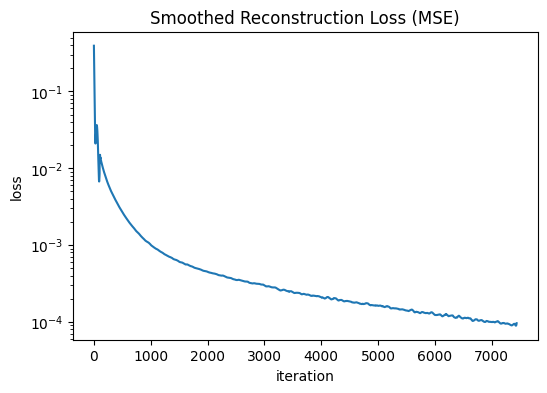

In [ ]:
# Smooth training losses
train_losses_smooth = savgol_filter(train_losses, 201, 7)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(train_losses_smooth)
plt.yscale("log")
plt.title("Smoothed Reconstruction Loss (MSE)")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [16]:
def generate(model, start_seq, max_len=200):
    """
    Autoregressively generate strokes from a start sequence.
    start_seq: (1, start_len, 3)
    """
    model.eval()
    start_seq = start_seq.to(device)
    generated = start_seq.clone()

    with torch.no_grad():
        # Encode once
        enc_output = model.encoder(start_seq)

        for _ in range(max_len - start_seq.size(1)):
            # Decoder input: generated sequence so far
            dec_input = generated

            dec_output = model.decoder(dec_input, enc_output)  # (1, seq_len, d_model)
            next_step = model.output_layer(
                dec_output[:, -1:, :]
            )  # last step prediction

            # Append predicted step
            generated = torch.cat([generated, next_step], dim=1)

    return generated


# Example usage
start_seq = training_data[0]  # (seq_len, 3)

from IPython.display import HTML, display

original_svg = tensor_to_svg_strokes(start_seq, size=128)
display(
    HTML(
        f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;">{original_svg}</div>'
    )
)

# remove some of the end to simulate partial input
start_seq = start_seq[:5, :]  # (start_len, 3)
start_seq = normalize_strokes(start_seq.unsqueeze(0))  # (1, seq_len, 3)

generated_seq = generate(model, start_seq, max_len=200)
print("Generated shape:", generated_seq.shape)

# denormalize
generated_seq = denormalize_strokes(generated_seq.squeeze(0)).cpu()
print(generated_seq)


svg = tensor_to_svg_strokes(generated_seq, size=128)

display(
    HTML(
        f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;">{svg}</div>'
    )
)

Generated shape: torch.Size([1, 200, 3])
tensor([[ 6.4000e+01,  3.6000e+01,  0.0000e+00],
        [-8.0000e+00, -1.6000e+01,  1.0000e+00],
        [-7.0000e+00, -7.0000e+00,  1.0000e+00],
        [ 5.0000e+00,  2.6000e+01,  1.0000e+00],
        [-1.6000e+01,  2.0000e+00,  1.0000e+00],
        [-1.5140e+01, -3.5558e+00,  9.7433e-01],
        [-1.3726e+01, -7.5254e+00,  9.4237e-01],
        [-1.1286e+01, -1.0032e+01,  8.9654e-01],
        [-8.8512e+00, -1.1762e+01,  8.3797e-01],
        [-6.7355e+00, -1.2990e+01,  7.6832e-01],
        [-4.7879e+00, -1.4557e+01,  6.8783e-01],
        [-2.8483e+00, -1.6502e+01,  5.9102e-01],
        [-5.4212e-01, -1.8529e+01,  4.4752e-01],
        [ 2.5557e+00, -2.0237e+01,  2.2039e-01],
        [ 5.7199e+00, -1.8424e+01,  1.5151e-02],
        [ 6.0012e+00, -1.3851e+01, -1.7995e-03],
        [ 5.6980e+00, -8.0621e+00, -1.8364e-03],
        [ 4.3594e+00, -2.5518e+00, -1.7585e-03],
        [ 2.0384e+00,  5.5226e-01, -2.1656e-03],
        [ 5.3649e-01,  1.286